<a href="https://colab.research.google.com/github/SanjanaRamoliya27/blip-weather-vqa/blob/main/EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


EDA For Project

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
import zipfile
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
from collections import Counter
import cv2
from sklearn.cluster import KMeans

# Define paths
zip_path = "/content/drive/MyDrive/weather.zip"
extract_path = "/content/ML_Blip_images"

# Extract ZIP file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

In [3]:
# List all image files
image_files = []
valid_extensions = ('.jpg', '.jpeg', '.png')
for root, _, files in os.walk(extract_path):
    for file in files:
        if file.lower().endswith(valid_extensions):
            image_files.append(os.path.join(root, file))

In [4]:
# Basic stats
total_images = len(image_files)
print(f"Total images found: {total_images}")

Total images found: 6862


/tmp/ipython-input-2294783319.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(format_counts.keys()), y=list(format_counts.values()), palette="viridis")


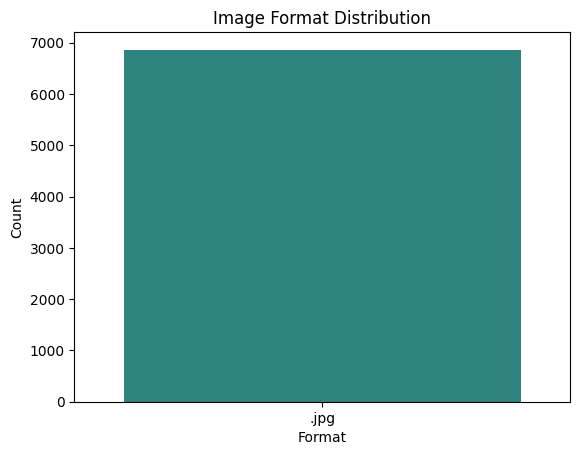

In [5]:
# Get image formats
formats = [os.path.splitext(img)[1].lower() for img in image_files]
format_counts = Counter(formats)
sns.barplot(x=list(format_counts.keys()), y=list(format_counts.values()), palette="viridis")
plt.title("Image Format Distribution")
plt.xlabel("Format")
plt.ylabel("Count")
plt.show()

In [6]:
# Analyze image sizes
image_sizes = []
for img_path in image_files:
    with Image.open(img_path) as img:
        image_sizes.append(img.size)  # (width, height)

widths, heights = zip(*image_sizes)

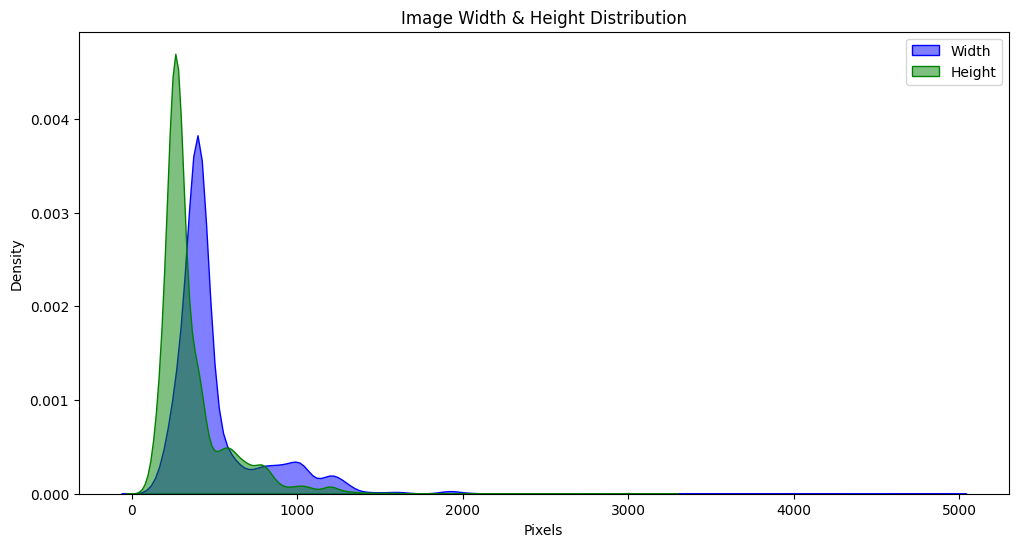

In [7]:
# Create a DataFrame for better visualization
df_sizes = pd.DataFrame({'Width': widths, 'Height': heights})
plt.figure(figsize=(12, 6))
sns.kdeplot(df_sizes['Width'], fill=True, label='Width', color='blue', alpha=0.5)
sns.kdeplot(df_sizes['Height'], fill=True, label='Height', color='green', alpha=0.5)
plt.title("Image Width & Height Distribution")
plt.xlabel("Pixels")
plt.ylabel("Density")
plt.legend()
plt.show()

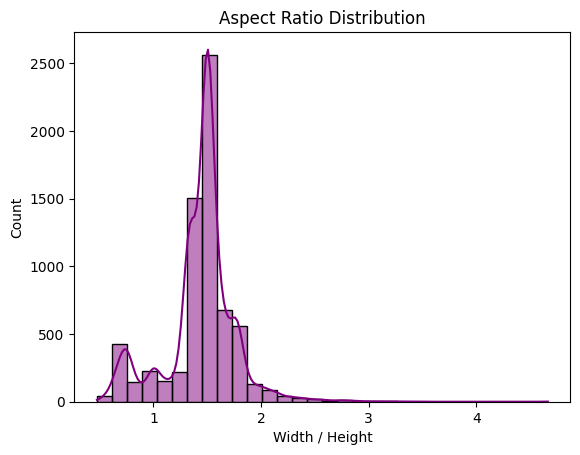

In [8]:
# Aspect ratio distribution
aspect_ratios = np.array(widths) / np.array(heights)
sns.histplot(aspect_ratios, bins=30, kde=True, color='purple')
plt.title("Aspect Ratio Distribution")
plt.xlabel("Width / Height")
plt.ylabel("Count")
plt.show()

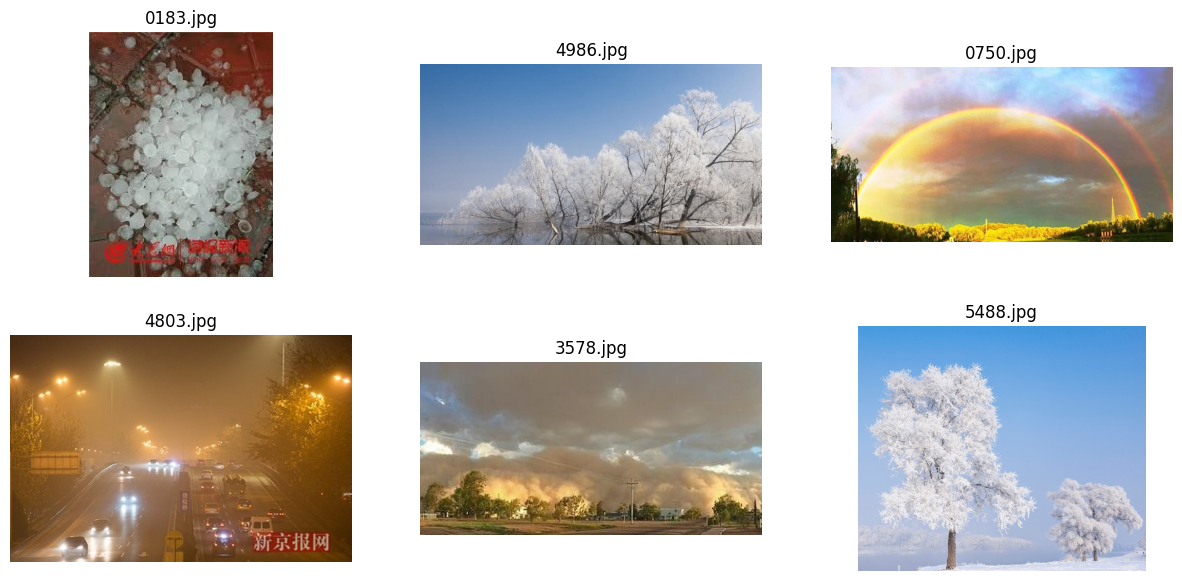

In [9]:
# Display random images
num_images_to_display = min(6, total_images)
random_images = random.sample(image_files, num_images_to_display)
fig, axes = plt.subplots(2, num_images_to_display // 2, figsize=(15, 7))
for ax, img_path in zip(axes.flat, random_images):
    image = Image.open(img_path).convert("RGB")
    ax.imshow(image)
    ax.set_title(os.path.basename(img_path))
    ax.axis("off")
plt.show()

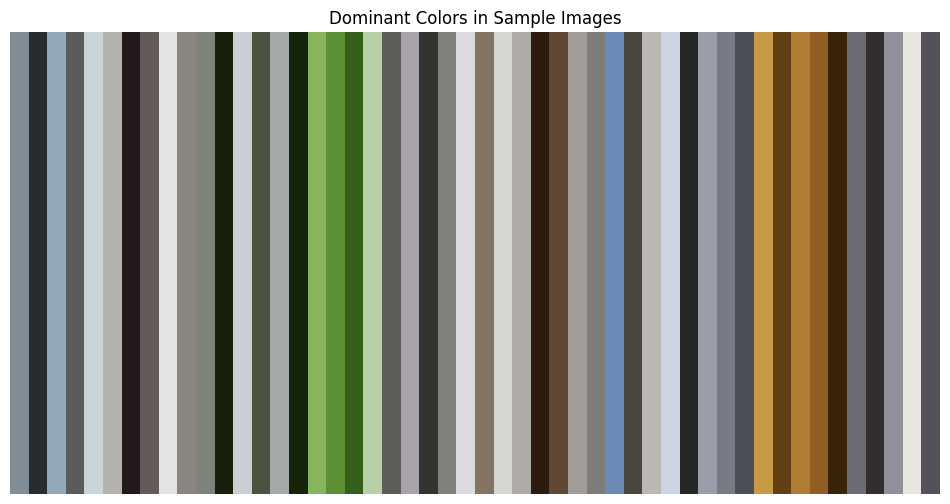

In [10]:
# Color analysis - Extract dominant colors from sample images
def get_dominant_colors(img_path, k=5):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.reshape((-1, 3))
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(img)
    return kmeans.cluster_centers_.astype(int)

random_sample = random.sample(image_files, min(10, total_images))
dominant_colors = [get_dominant_colors(img) for img in random_sample]
dominant_colors = np.array(dominant_colors).reshape(-1, 3)

plt.figure(figsize=(12, 6))
plt.imshow([dominant_colors], aspect='auto')
plt.title("Dominant Colors in Sample Images")
plt.axis("off")
plt.show()

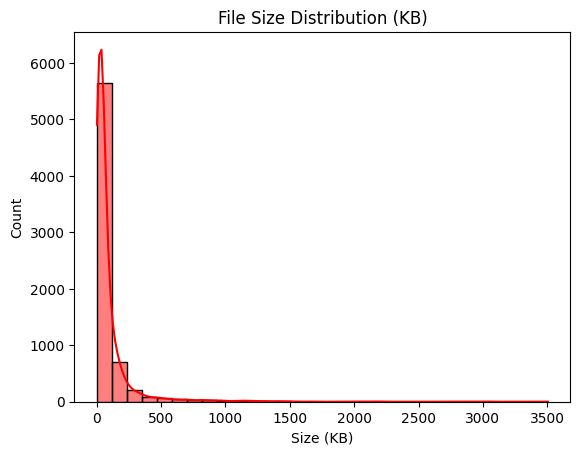

In [11]:
# File size analysis
file_sizes = [os.path.getsize(img) / 1024 for img in image_files]  # Convert to KB
sns.histplot(file_sizes, bins=30, kde=True, color='red')
plt.title("File Size Distribution (KB)")
plt.xlabel("Size (KB)")
plt.ylabel("Count")
plt.show()

In [12]:
!pip install imagehash

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.7/296.7 kB 25.0 MB/s eta 0:00:00


In [13]:
# Duplicate Image Detection (Perceptual Hashing)
from imagehash import phash
hashes = {}
duplicates = []
for img_path in image_files:
    with Image.open(img_path) as img:
        img_hash = phash(img)
        if img_hash in hashes:
            duplicates.append((hashes[img_hash], img_path))
        else:
            hashes[img_hash] = img_path

print(f"Total Duplicate Images Found: {len(duplicates)}")
if duplicates:
    print("Example duplicates:", duplicates[:3])

Total Duplicate Images Found: 356
Example duplicates: [('/content/ML_Blip_images/weather/rainbow/0641.jpg', '/content/ML_Blip_images/weather/rainbow/0664.jpg'), ('/content/ML_Blip_images/weather/rainbow/0638.jpg', '/content/ML_Blip_images/weather/rainbow/0660.jpg'), ('/content/ML_Blip_images/weather/rainbow/0649.jpg', '/content/ML_Blip_images/weather/rainbow/0656.jpg')]


In [14]:
import os
import shutil

dup_dir = "duplicates_found/"
os.makedirs(dup_dir, exist_ok=True)

for original, duplicate in duplicates:
    new_path = os.path.join(dup_dir, os.path.basename(duplicate))
    shutil.move(duplicate, new_path)
    print(f"Moved {duplicate} → {new_path}")


Moved /content/ML_Blip_images/weather/rainbow/0664.jpg → duplicates_found/0664.jpg
Moved /content/ML_Blip_images/weather/rainbow/0660.jpg → duplicates_found/0660.jpg
Moved /content/ML_Blip_images/weather/rainbow/0656.jpg → duplicates_found/0656.jpg
Moved /content/ML_Blip_images/weather/rainbow/0644.jpg → duplicates_found/0644.jpg
Moved /content/ML_Blip_images/weather/rainbow/0636.jpg → duplicates_found/0636.jpg
Moved /content/ML_Blip_images/weather/rainbow/0661.jpg → duplicates_found/0661.jpg
Moved /content/ML_Blip_images/weather/sandstorm/3129.jpg → duplicates_found/3129.jpg
Moved /content/ML_Blip_images/weather/sandstorm/3478.jpg → duplicates_found/3478.jpg
Moved /content/ML_Blip_images/weather/sandstorm/3097.jpg → duplicates_found/3097.jpg
Moved /content/ML_Blip_images/weather/sandstorm/3572.jpg → duplicates_found/3572.jpg
Moved /content/ML_Blip_images/weather/sandstorm/3434.jpg → duplicates_found/3434.jpg
Moved /content/ML_Blip_images/weather/sandstorm/3372.jpg → duplicates_found/3